# Load Our datasets

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

# LOAD entire csv examples 
acc_data = pd.read_csv('./datasets/our/AccData.txt')
gyro_data = pd.read_csv('./datasets/our/GyroData.txt')

print(acc_data)
print(gyro_data)


            timestamp         x         y          z user activity position
0       1609679149640 -0.820140  5.949155   8.282756    a     bike    right
1       1609679149658 -5.568098 -1.932204   7.171289    a     bike    right
2       1609679149721 -6.454639 -3.129812   6.457032    a     bike    right
3       1609679149724 -6.488139 -3.374478   6.366105    a     bike    right
4       1609679149729 -6.497710 -3.345764   6.246463    a     bike    right
...               ...       ...       ...        ...  ...      ...      ...
840578  1609671917685 -1.170090  1.900499  10.380663    a     walk     hand
840579  1609671917695 -1.208375  2.067997   9.897313    a     walk     hand
840580  1609671917697 -1.131805  2.944967   8.085946    a     walk     hand
840581  1609671917700 -1.122234  3.074179   7.774879    a     walk     hand
840582  1609671917713 -1.189233  3.247060   7.601997    a     walk     hand

[840583 rows x 7 columns]
            timestamp         x         y         z user    a

In [2]:
activities = acc_data['activity'].unique()

print(activities)



['bike' 'noactivity' 'stairsup' 'stairsdown' 'walk']


In [3]:
# SORT ACTIVITIES BY TIMESTAMP
acc_data.sort_values(by='timestamp', inplace=True)
gyro_data.sort_values(by='timestamp', inplace=True)

In [4]:
print(acc_data['timestamp'].is_monotonic)
print(gyro_data['timestamp'].is_monotonic)

True
True


In [5]:
def retrive_correct_min_max_timestamp(acc_data, gyro_data):
    min_acc_timestamp = acc_data['timestamp'].iloc[0]
    min_gyro_timestamp = gyro_data['timestamp'].iloc[0]
    max_acc_timestamp = acc_data['timestamp'].iloc[-1]
    max_gyro_timestamp = gyro_data['timestamp'].iloc[-1]

    difference_in_min = min_acc_timestamp - min_gyro_timestamp
    difference_in_max = max_acc_timestamp - max_gyro_timestamp

    if((abs(difference_in_min) > 200) or (abs(difference_in_max) > 200)):
        print('ERROR! Difference beetween timestamp is too high')
        return (0, 0)

    min_timestamp = np.min(np.array([min_acc_timestamp, min_gyro_timestamp]).astype(int))
    max_timestamp = np.max(np.array([max_acc_timestamp, max_gyro_timestamp]).astype(int))

    return (min_timestamp, max_timestamp)

In [6]:
def add_time_intervals(acc_data, gyro_data):
    #Sorting elements, even if it is not required!
    acc_data.sort_values(by='timestamp', inplace = True)
    gyro_data.sort_values(by='timestamp', inplace = True)

    acc_data['next_timestamp'] = acc_data['timestamp'].shift(1)
    gyro_data['next_timestamp'] = gyro_data['timestamp'].shift(1)

    # Calculating time interval beetween samples
    acc_data['time_interval'] = acc_data['timestamp'].sub(acc_data['next_timestamp'], axis=0)
    gyro_data['time_interval'] = gyro_data['timestamp'].sub(gyro_data['next_timestamp'], axis=0)

    # ERASE LAST ROW
    acc_data.dropna(inplace=True)
    gyro_data.dropna(inplace=True)

    acc_data.drop(columns=['next_timestamp'], inplace=True)
    gyro_data.drop(columns=['next_timestamp'], inplace=True)


    return acc_data, gyro_data


In [7]:
def get_activity_actions (acc_data, gyro_data, max_allowed_interval=300.0, min_time_s_activity=2.5):

    acc_data, gyro_data = add_time_intervals(acc_data, gyro_data)

    # extracting index that the activity is splitted
    acc_splitting_index = acc_data[(acc_data['time_interval'] > max_allowed_interval)].index.values
    gyro_splitting_index = gyro_data[(gyro_data['time_interval'] > max_allowed_interval)].index.values

    if(len(acc_splitting_index) != len(gyro_splitting_index)):
        print(len(acc_splitting_index))
        print(len(gyro_splitting_index))
        print('ERROR!!! No matching index to split')
        return ([],[])

    # Adding 1 to all index because we want the next element
    acc_splitting_index = acc_splitting_index 
    gyro_splitting_index = gyro_splitting_index 

    starting_acc_index = acc_data.head(1).index[0]
    ending_acc_index = acc_data.tail(1).index[0]

    starting_gyro_index = gyro_data.head(1).index[0]
    ending_gyro_index = gyro_data.tail(1).index[0]

    acc_splitting_index = np.insert(acc_splitting_index, 0, starting_acc_index)
    gyro_splitting_index = np.insert(gyro_splitting_index, 0, starting_gyro_index)

    acc_splitting_index = np.append(acc_splitting_index, ending_acc_index)
    gyro_splitting_index = np.append(gyro_splitting_index, ending_gyro_index)

    activity_acc_data = []
    activity_gyro_data = []

    for i in range (0, len(acc_splitting_index)-1):
        single_act_acc = acc_data.loc[acc_splitting_index[i]:acc_splitting_index[i+1]].iloc[:-1]
        single_act_gyro = gyro_data.loc[gyro_splitting_index[i]:gyro_splitting_index[i+1]].iloc[:-1]

        min_creation_time, max_creation_time = retrive_correct_min_max_timestamp(single_act_acc, single_act_gyro)
    
        time_seconds_interval = ((max_creation_time - min_creation_time) / 1000)

        if(time_seconds_interval < min_time_s_activity):
            print('activity_too_short')
            continue

        activity_acc_data.append(single_act_acc)
        activity_gyro_data.append(single_act_gyro)

    
    return (activity_acc_data, activity_gyro_data)

activity_acc_data, activity_gyro_data = get_activity_actions(acc_data, gyro_data)
print(len(activity_acc_data), len(activity_gyro_data))

157 157


# TRY WITH INTERPOLATION

In [8]:

def get_interpolated_data(acc_data, gyro_data, samples_frequency):
    min_creation_time, max_creation_time = retrive_correct_min_max_timestamp(acc_data, gyro_data)
    
    time_seconds_interval = ((max_creation_time - min_creation_time) / 1000)

    n_samples=int(math.trunc(time_seconds_interval * samples_frequency))

    time_interpolation = np.linspace(min_creation_time, max_creation_time, num=n_samples)
    acc_timestamp = np.array(acc_data['timestamp']).astype(int)
    x_acc = np.array(acc_data['x']).astype(int)
    y_acc = np.array(acc_data['y']).astype(int)
    z_acc = np.array(acc_data['z']).astype(int)
    x_interpolated_acc = np.interp(time_interpolation, acc_timestamp, x_acc)
    y_interpolated_acc = np.interp(time_interpolation, acc_timestamp, y_acc)
    z_interpolated_acc = np.interp(time_interpolation, acc_timestamp, z_acc)

    interpolated_acc = np.vstack((x_interpolated_acc, y_interpolated_acc, z_interpolated_acc))

    gyro_timestamp = np.array(gyro_data['timestamp']).astype(int)
    x_gyro = np.array(gyro_data['x']).astype(int)
    y_gyro = np.array(gyro_data['y']).astype(int)
    z_gyro = np.array(gyro_data['z']).astype(int)

    x_interpolated_gyro = np.interp(time_interpolation, gyro_timestamp, x_gyro)
    y_interpolated_gyro = np.interp(time_interpolation, gyro_timestamp, y_gyro)
    z_interpolated_gyro = np.interp(time_interpolation, gyro_timestamp, z_gyro)

    interpolated_gyro = np.vstack((x_interpolated_gyro, y_interpolated_gyro, z_interpolated_gyro))

    return interpolated_acc, interpolated_gyro, time_interpolation



            timestamp          x         y         z user activity position  \
619093  1609669995052 -10.249058  0.276371  0.985843    a     walk    right   
619094  1609669995056 -10.632507  0.037089  1.316651    a     walk    right   
619095  1609669995060 -10.828719 -0.006580  1.326222    a     walk    right   
619096  1609669995062 -11.197812 -0.303290  1.354936    a     walk    right   
619097  1609669995091 -12.016755 -1.266401  1.579861    a     walk    right   
...               ...        ...       ...       ...  ...      ...      ...   
645446  1609670194572 -10.095917  0.080160 -1.534397    a     walk    right   
645447  1609670194575 -12.078969 -1.395614 -5.434100    a     walk    right   
645448  1609670194588 -13.363317 -0.547956 -4.653442    a     walk    right   
645449  1609670194591 -13.535600 -0.442074 -4.773083    a     walk    right   
645450  1609670194603 -13.703097 -0.375075 -4.969295    a     walk    right   

        time_interval  
619093           13.0  
619

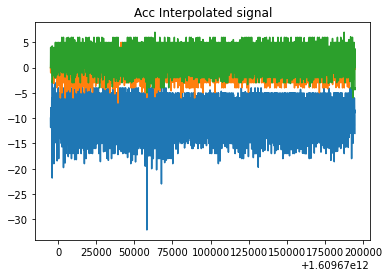

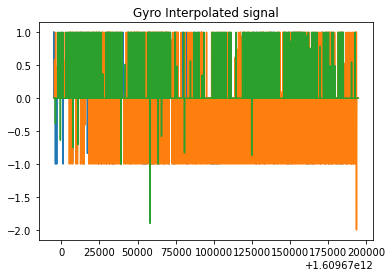

In [9]:
selected_trace = 0

interpolated_acc, interpolated_gyro, time_interpolation = get_interpolated_data(activity_acc_data[selected_trace], activity_gyro_data[selected_trace], samples_frequency=50)

print(activity_acc_data[selected_trace])


plt.plot(time_interpolation, interpolated_acc.T)
plt.title('Acc Interpolated signal')
plt.show()


plt.plot(time_interpolation, interpolated_gyro.T)
plt.title('Gyro Interpolated signal')
plt.show()

159
(3, 125)


<Figure size 432x288 with 0 Axes>

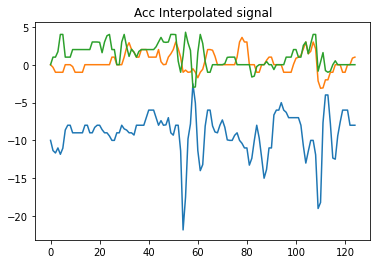

<Figure size 432x288 with 0 Axes>

In [10]:
# REQUIREMENTS: This function ONLY work if the activity are already interpolated
def generate_time_windows(acc_data, gyro_data, sampling_frequency, seconds_in_time_window, overlapping_pencentage=0.5):
    n_samples = acc_data.shape[1]
    
    # ES: Se voglio campionare a 50 hz in un intervallo di 2.5 allora mi servono 2.5 * 50 campioni
    samples_in_time_window = int(seconds_in_time_window * sampling_frequency)

    shift_index = int(np.floor(samples_in_time_window * (1-overlapping_pencentage)))

    extracted_acc_time_windows = []
    extracted_gyro_time_windows = []

    start_index = 0
    final_index = samples_in_time_window

    while(True):

        if(final_index > n_samples):
            break

        extracted_acc_samples = acc_data[:, start_index:final_index]
        extracted_gyro_samples = gyro_data[:, start_index:final_index]

        extracted_acc_time_windows.append(extracted_acc_samples)
        extracted_gyro_time_windows.append(extracted_gyro_samples)

        start_index = start_index + shift_index
        final_index = start_index + samples_in_time_window

    return extracted_acc_time_windows, extracted_gyro_time_windows

interpolated_acc, interpolated_gyro, time_interpolation = get_interpolated_data(activity_acc_data[0], activity_gyro_data[0], samples_frequency=50)

extracted_acc_time_windows, extracted_gyro_time_windows = generate_time_windows(interpolated_acc, interpolated_gyro, 50, 2.5)
print(len(extracted_acc_time_windows))
print(extracted_acc_time_windows[0].shape)

plt.plot(extracted_acc_time_windows[0].T)
plt.title('Acc Interpolated signal')
plt.figure()



In [11]:
# CHECK AND BUILD OUR DATASET FOR THEIR BUGS
samples_frequency_we_want = 50
time_window_seconds = 2.5

#creating file 
f_dataset = open(f"./datasets/our/our_dataset_{samples_frequency_we_want}_{time_window_seconds}.csv","w+")
f_labels = open(f"./datasets/our/our_dataset_labels_{samples_frequency_we_want}_{time_window_seconds}.csv","w+")

    
for i in range(0, len(activity_acc_data)):

    user='a'
    device='oneplus_8t'

    single_act_acc = activity_acc_data[i]
    single_act_gyro = activity_gyro_data[i]

    # check activity inside in a single activity
    lst_acc_activities=single_act_acc['activity'].unique()
    lst_gyro_activities=single_act_gyro['activity'].unique()

    if(len(lst_acc_activities) == 1 and lst_acc_activities == lst_gyro_activities):
        activity=lst_acc_activities[0]
    else:
        print('ERROR: Activity is not unique')
        continue

    # check position inside in a single activity
    lst_acc_positions=single_act_acc['position'].unique()
    lst_gyro_positions=single_act_gyro['position'].unique()

    if(len(lst_acc_positions) == 1 and lst_acc_positions == lst_gyro_positions):
        position=lst_acc_positions[0]
    else:
        print('ERROR: Position is not unique')
        continue
    
    
    # 1D INTERPOLATION
    interpolated_acc, interpolated_gyro, _ = get_interpolated_data(single_act_acc, single_act_gyro, samples_frequency=samples_frequency_we_want)

    #CREATE ALL TIME_WINDOWS AL SAVE THE FILE
    extracted_acc_time_windows, extracted_gyro_time_windows = generate_time_windows(interpolated_acc, interpolated_gyro, samples_frequency_we_want, time_window_seconds, 0.5)

    number_extracted_time_windows = len(extracted_acc_time_windows)

    for i in range(0, number_extracted_time_windows):
        acc_signal = extracted_acc_time_windows[i]
        gyro_signal = extracted_gyro_time_windows[i]

        total_signal = np.vstack((acc_signal, gyro_signal))

        total_signal_flatted = total_signal.flatten()

        total_signal_flatted.tofile(f_dataset,sep=',')
        f_dataset.write('\n')

        f_labels.write(f'{user},{device},{activity},{position}\n')


f_dataset.close()
f_labels.close()



# FIN QUI NON FUNZIONA NIENTE GRAZIE AI LORO TIMESTAMP BUGGATI!!!

In [66]:
acc_examples_for_activity = acc_df_example.shape[0]
gyro_examples_for_activity = gyro_df_example.shape[0]

print(acc_examples_for_activity, gyro_examples_for_activity)

55163 55166


## 1D Data Interpolation

In [29]:
print(np.array(acc_df_example['Creation_Time']).astype(int))

[1424696631913 1424696631918 1424696631923 ... 1424696930030 1424696930035
 1424696930040]


<Figure size 432x288 with 0 Axes>

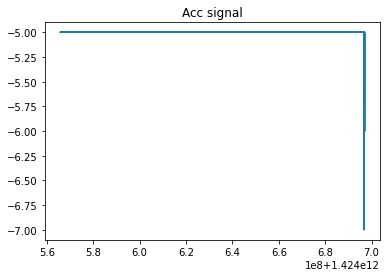

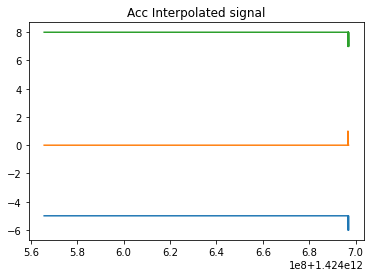

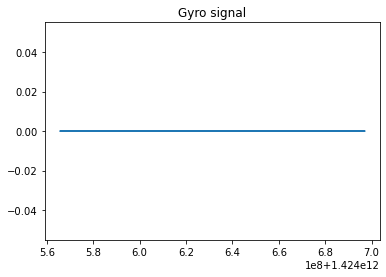

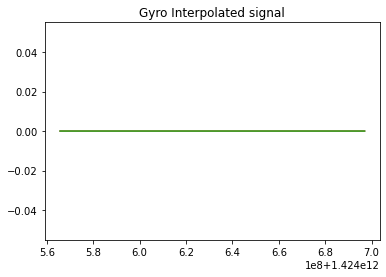

<Figure size 432x288 with 0 Axes>

In [33]:
import matplotlib.pyplot as plt

time_interpolation = np.linspace(min_creation_time, max_creation_time, num=60000)
acc_timestamp = np.array(acc_df_example['Creation_Time']).astype(int)
x_acc = np.array(acc_df_example['x']).astype(int)
y_acc = np.array(acc_df_example['y']).astype(int)
z_acc = np.array(acc_df_example['z']).astype(int)
x_interpolated_acc = np.interp(time_interpolation, acc_timestamp, x_acc)
y_interpolated_acc = np.interp(time_interpolation, acc_timestamp, y_acc)
z_interpolated_acc = np.interp(time_interpolation, acc_timestamp, z_acc)

intepolated_acc = np.vstack((x_interpolated_acc, y_interpolated_acc, z_interpolated_acc)).T

gyro_timestamp = np.array(gyro_df_example['Creation_Time']).astype(int)
x_gyro = np.array(gyro_df_example['x']).astype(int)
y_gyro = np.array(gyro_df_example['y']).astype(int)
z_gyro = np.array(gyro_df_example['z']).astype(int)

x_interpolated_gyro = np.interp(time_interpolation, gyro_timestamp, x_gyro)
y_interpolated_gyro = np.interp(time_interpolation, gyro_timestamp, y_gyro)
z_interpolated_gyro = np.interp(time_interpolation, gyro_timestamp, z_gyro)

intepolated_gyro = np.vstack((x_interpolated_gyro, y_interpolated_gyro, z_interpolated_gyro)).T

plt.plot(acc_timestamp, x_acc)
plt.title('Acc signal')
plt.figure()

plt.plot(time_interpolation, intepolated_acc)
plt.title('Acc Interpolated signal')
plt.figure()

plt.plot(gyro_timestamp, x_gyro)
plt.title('Gyro signal')
plt.figure()

plt.plot(time_interpolation, intepolated_gyro)
plt.title('Gyro Interpolated signal')
plt.figure()


In [ ]:
for user in users:
    for device in devices:
        for activity in activities:

            #EXTRACTING ACTIVITY DATA
            df = acc_data.loc[(acc_data['User'] == users[0]) & (acc_data['Device'] == devices[0]) & (acc_data['gt'] == activities[0])]


In [ ]:

# Keep 20% of the data out for validation
### START CODE HERE ### (1 line)
train_reference_df, val_reference_df = train_test_split(reference_df, test_size=0.2, shuffle=True, random_state=123)
### END CODE HERE ###


def print_dataset_statistics(train_reference_df, val_reference_df):

    # Count the elements in the sets
    num_train_data_no_activity = sum(train_reference_df['NO_ACTIVITY'] == 1)
    num_train_data_walking   = sum(train_reference_df['WALKING'] == 1)
    num_train_data_driving = sum(train_reference_df['DRIVING'] == 1)
    num_train_data_bus = sum(train_reference_df['BUS'] == 1)
    num_train_data_bicycling = sum(train_reference_df['BICYCLING'] == 1)
    num_train_data_stairs = sum(train_reference_df['STAIRS'] == 1)
    num_train_data_elevator = sum(train_reference_df['ELEVATOR'] == 1)

    num_val_data_no_activity = sum(val_reference_df['NO_ACTIVITY'] == 1)
    num_val_data_walking   = sum(val_reference_df['WALKING'] == 1)
    num_val_data_driving = sum(val_reference_df['DRIVING'] == 1)
    num_val_data_bus = sum(val_reference_df['BUS'] == 1)
    num_val_data_bicycling   = sum(val_reference_df['BICYCLING'] == 1)
    num_val_data_stairs  = sum(val_reference_df['STAIRS'] == 1)
    num_val_data_elevator = sum(val_reference_df['ELEVATOR'] == 1)



    print('TRAIN SET')
    print('\tNo activity: {} ({:.2f}%)'.format(num_train_data_no_activity, 100 * num_train_data_no_activity / len(train_reference_df)))
    print('\tWalking: {} ({:.2f}%)'.format(num_train_data_walking, 100 * num_train_data_walking / len(train_reference_df)))
    print('\tDriving: {} ({:.2f}%)'.format(num_train_data_driving, 100 * num_train_data_driving / len(train_reference_df)))
    print('\tBus: {} ({:.2f}%)'.format(num_train_data_bus, 100 * num_train_data_bus / len(train_reference_df)))
    print('\tBicycling: {} ({:.2f}%)'.format(num_train_data_bicycling, 100 * num_train_data_bicycling / len(train_reference_df)))
    print('\tStairs: {} ({:.2f}%)'.format(num_train_data_stairs, 100 * num_train_data_stairs / len(train_reference_df)))
    print('\tElevator: {} ({:.2f}%)'.format(num_train_data_elevator, 100 * num_train_data_elevator / len(train_reference_df)))


    print('VALIDATION SET')
    print('\tNo activity: {} ({:.2f}%)'.format(num_val_data_no_activity, 100 * num_val_data_no_activity / len(val_reference_df)))
    print('\tWalking: {} ({:.2f}%)'.format(num_val_data_walking, 100 * num_val_data_walking / len(val_reference_df)))
    print('\tDriving: {} ({:.2f}%)'.format(num_val_data_driving, 100 * num_val_data_driving / len(val_reference_df)))
    print('\tBus: {} ({:.2f}%)'.format(num_val_data_bus, 100 * num_val_data_bus / len(val_reference_df)))
    print('\tBicycling: {} ({:.2f}%)'.format(num_val_data_bicycling, 100 * num_val_data_bicycling / len(val_reference_df)))
    print('\tStairs: {} ({:.2f}%)'.format(num_val_data_stairs, 100 * num_val_data_stairs / len(val_reference_df)))
    print('\tElevator: {} ({:.2f}%)'.format(num_val_data_elevator, 100 * num_val_data_elevator / len(val_reference_df)))


print_dataset_statistics(train_reference_df, val_reference_df)